In [7]:
"""Generating the HAM model from input MHD simulation

Marius Ramsøy 22/9/22"""


##########################################
#Files for download may be found here:
#https://cloud.aquila-consortium.org/s/jsNxieJyxWPPLnF?path=%2FHAM
#This uses the TNG-100 simulation as a refenence and projects it
#onto the Sibelius simulation

##########################################


import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import numpy as np
from matplotlib import colors
import healpy as hp
import struct
from astropy_healpix import HEALPix 
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo


import progressbar
import progress

import time
import random
import h5py as h5
import copy
import os
import sys


import healpy as hp
import struct
from astropy_healpix import HEALPix 
from astropy.coordinates import SkyCoord
from astropy import units as u

import cosmotool
import progressbar
import progress

import time
import random
import h5py as h5
import copy
import numpy as np
import os
from FyeldGenerator import generate_field



from scipy.ndimage import map_coordinates
from scipy.interpolate import interp1d
from scipy.interpolate import griddata


def smooth(y,N=None):
    if(N==None):
        N=1
    print(N)
    yt=y.copy()
    if(len(y.shape)==1):
        for _ in range(N):

            #pcen

            ytemp=np.zeros((yt.size)+1,dtype=yt.dtype)
            ytemp[0]=y[0]
            ytemp[-1]=y[-1]
            ytemp[1:-1]=(yt[0:-1]+yt[1:None])/2

            #zcen
            yt=(ytemp[0:-1]+ytemp[1:None])/2
            
        #zcen
        if(N==0): return y.copy()
        return yt
    elif(len(y.shape)==3):
        for _ in range(N):

            #pcen

            ytemp=np.zeros(((yt.shape)[0]+1,(yt.shape)[1],(yt.shape)[2]),dtype=yt.dtype)
            ytemp[0,:,:]=y[0,:,:]
            ytemp[-1,:,:]=y[-1,:,:]
            ytemp[1:-1,:,:]=(yt[0:-1,:,:]+yt[1:None,:,:])/2
            print('W I P')
            ytemp[:,0,:]=y[:,0,:]
            ytemp[:,:,-1]=y[:,:,-1]
            ytemp[:,-1,:]=y[:,-1,:]
            
            #zcen
            yt=(ytemp[0:-1,0:-1,0:-1]+ytemp[1:None,1:None,1:None])/2
        #zcen
        if(N==0): return y.copy()
        return yt

def rotateArray(arr,angle,axis=0,fill_value=0,method='linear'):
    N=arr.shape[0]
    trp=[axis]+list({0,1,2}-{axis,axis})
              
    rt=np.transpose(arr.copy(),trp)
    x=np.repeat(np.expand_dims(np.linspace(-1,1,N),axis=1),N,axis=1)
    y=x.T
    yp=x*np.sin(angle)+y*np.cos(angle)
    xp=x*np.cos(angle)-y*np.sin(angle)
    #stat(x,y,xp,yp)
    rt2=np.zeros((N,N*N))
    #stat(np.array([x.ravel(),y.ravel()]))
    #for i in range(N):
    for i in progressbar(range(N), "Computing: ", 40):    
        temp=griddata((x.ravel(),y.ravel()),rt[i,:,:].ravel(),(xp.ravel(),yp.ravel()),method=method,fill_value=fill_value)
        rt2[i,:]=temp.copy()
    
    return np.transpose(rt2.reshape((N,N,N)),np.sort(trp))

def smooth3d(field,N=1):
    return field
    for n in range(N):
        field2=field.copy()*0
        for i in range(2):
            for j in range(2):
                for k in range(2):
                    field2+=np.roll(field,[i,j,k,0],axis=(0,1,2,3))
        

        field=field2/8
    return field



def scale_up(field,N=1):
    #not intended as opposite to interp_down
    #works on 3d field, not face field
    
    for n in range(N):
        dims=field.shape
        field2=np.zeros((dims[0]*2,dims[1]*2,dims[2]*2),dtype=field.dtype)
        for i in range(2):
            for j in range(2):
                for k in range(2):


                    field2[i::2,j::2,k::2]=field
        field=field2.copy()
    return field
    




def profile_rescale(profiles,N2,s=1):
    N1,n=profiles.shape
    
    p2=np.zeros((N2,n),dtype=float)
    r=np.linspace(1,N1,num=N1,endpoint=True)/N1/s
    rnew=np.linspace(1,N2,num=N2,endpoint=True)/N2
    
    #for i in progressbar(range(n), "Computing: ", 40):
    count=0
    print('interpolating profiles')
    for i in range(n):
        if(i%1000==0):
            print(100*i//n,"%")
        if(np.mean(profiles[:,i])==0):
            if(count>100):
                break
                #stop once 100 halos in a row hoave no profile
                #every other profile has then been wiped out by
                #larger halos
            else:
                count+=1
        else:
            count=0
           
        fr2 = interp1d(r, profiles[:,i]*r**2, kind='cubic',fill_value=(profiles[0,i]*r[0]**2,0),bounds_error=False) 
        
        r2=interp1d(r, r**2, kind='cubic',fill_value=(rnew[0]**2,rnew[-1]**2),bounds_error=False)
        p2[:,i]=abs(fr2(rnew)/r2(rnew))
        
        x=np.where(profiles[:,i]==0)[0]
        if(x.size!=0):
            x=x[0]
        else:
            x=0
        x=np.where(rnew>r[x])[0]
        if(x.size):
            p2[x[0]:None,i]=0
    return p2






def norm(v):
    l=len(v.shape)
    
    L=np.sqrt(np.sum(v**2,axis=l-1))
    #if(L==0):
    #    L=1
    return L



def stat(*args):
    i=0
    for arr in args:
        i=i+1
        print('array: '+str(i)+' shape:',arr.shape,"min: ",np.min(arr),"max: ",np.max(arr),"avg: ",np.mean(arr),"std: ",np.std(arr))
    

def progressbar(it, prefix="", size=60, file=sys.stdout):
    #usage:
    
    # for i in progressbar(range(N), "Computing: ", 40):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()        
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()
    
def Pkgen(n1,cut,n2,exp_cut,kfloor):
    
    def Pk(k):
        arr=k.copy()
        
        if(exp_cut==False):
            ppp=np.where(k<cut,np.power(k+kfloor,n1),np.power(k+kfloor,n2)*(cut+kfloor)**(-n2+n1))
        else:
            ppp=np.where(k<cut,np.power(k+kfloor,n1),np.exp(-(k+kfloor)/n2)/(cut+kfloor)**(-n1)/np.exp(-(cut+kfloor)/n2))
        
        
        return ppp

    return Pk

def distrib(shape):
    a = np.random.normal(loc=0, scale=1, size=shape)
    b = np.random.normal(loc=0, scale=1, size=shape)
    return a + 1j * b


def GRF(shape,n1,cut,n2,exp_cut,kfloor):
    #cut should be at N*0.5/shape[0] roughly
    #if using exponential cut-off, then same order should be used to 
    #pick the scale
    #example 
    
    #shape=(N,N)
    #field=GRF(shape,4,50*0.5/N,0.1*0.5/N,True,0.5/N)
    
    

    return generate_field(distrib,Pkgen(n1,cut,n2,exp_cut,kfloor), shape)





def fg_load(fname,subtract):
    #'faraday2020.hdf5'
    f=h5.File(fname,'r')

    asm=np.array(f[list(f.keys())[0]],float)
    if(subtract==1):
        asd=np.array(f[list(f.keys())[1]],float)

        asd=np.random.normal(0,asd)
        return asd
    return asm

def hp_interp(hp_in,nside_in,nside_out,frame_in='icrs',frame_out='icrs',long_rotate=0):
    hpp2=HEALPix(nside=nside_out,frame=frame_out)                                                                                                                                                                                 
    lon2, lat2 = hpp2.healpix_to_lonlat(range(hpp2.npix))
    
    coords = SkyCoord(lon2+long_rotate*u.deg, lat2,frame=frame_out)

    hpp=HEALPix(nside=nside_in,frame=frame_in)
    v=np.array(hpp.interpolate_bilinear_skycoord(coords, hp_in),float)
    return v




In [4]:
def p_field_gen(density,amplitude=1e-14,frac=0.1,scale=16):
    """Produces a primordial field with a broken powerlaw index 4 
    rising and -5/3 falling with a peak at 16 cells (default)
    Typically this component will be quite weak so can choose to
    ignore it.
    """
    shape=density.shape[0]
   
   
   
    n1=4-2
    n2=-5/3*2-2
    exp_cut=False

    cut=scale
    r1=GRF((shape,shape,shape),n1*2,30*0.5/shape,n2,exp_cut,0.5/shape/10)
    N=np.std(r1)
    r1/=N

    r2=GRF((shape,shape,shape),n1*2,30*0.5/shape,n2,exp_cut,0.5/shape/10)/N
    r3=GRF((shape,shape,shape),n1*2,30*0.5/shape,n2,exp_cut,0.5/shape/10)/N
    Bf=np.zeros((shape,shape,shape,3))
    
    Bog=((density/np.mean(density))**(2./3))
    Bf[:,:,:,0]=(Bog*frac*r1)
    Bf[:,:,:,1]=(Bog*frac*r2)
    Bf[:,:,:,2]=(Bog*(1+frac*r3))
    Bf=Bf/np.mean(np.sqrt(np.sum(Bf**2,axis=3)))*amplitude
    
    return Bf#Bf[:,:,:,0].ravel(),Bf[:,:,:,1].ravel(),Bf[:,:,:,2].ravel()

def index_shells(N_shell,N_cell):
    indexes=[]
    s=N_cell
    
    rt=np.linspace(-s/2,s/2-1,s)
    rz=np.tile(rt,(s,s,1))
    ry=np.transpose(rz,(0,2,1))
    rx=np.transpose(rz,(2,1,0))
    r=np.sqrt(rx*rx+ry*ry+rz*rz)
    rz=ry=rx=rt=[]
    r=np.array(r,dtype=int)
   
    r=np.roll(r,-int(N_cell/2),axis=(0,1,2))
    print('indexing\n...\nThis may take some time the first time')
    for i in range(N_shell):
            print(int(1000*i/N_shell)/10,"%")
            #gather the indices
            U=np.array(np.where(r==i))
            U=np.array(U)
            indexes.append(U)
            #indexes.append(np.unravel_index((np.where(r==i)[0]),(N_cell,N_cell,N_cell)))
    print(100,"%")
    return indexes


def load_index(N_shell,N_cell):
    """Loads the relative positions of the cells on each of the N_SHELL shells of cells.
    N_CELL is the number side length of the box in cells.  When first run it will save the
    indices so it doesn't have to rerun the whole thing later"""
    if((os.path.isfile('indexes_'+str(N_shell)+'_'+str(N_cell)+'.tmp.h5'))):
        hf=h5.File('indexes_'+str(N_shell)+'_'+str(N_cell)+'.tmp.h5','r')
        #indexes=[hf[key][()] for key in list(hf.keys())]
        #keys arranged alphabetically
        #->
        indexes=[hf['L_'+str(i)][()] for i in range(N_shell)]
        hf.close()
        return indexes
    else:
        #numpy doesn't like lists of lists
        indexes=index_shells(N_shell,N_cell)
        hf = h5.File('indexes_'+str(N_shell)+'_'+str(N_cell)+'.tmp.h5', 'w')
        for i in range(N_shell):
            hf.create_dataset("L_"+str(i), data=indexes[i])
        hf.close()

       # np.savez('indexes_'+str(N_shell)+'_'+str(N_cell)+'.tmp',np.array(indexes,dtype=object))


def get_B_profiles(pos,M,B,dens,indexes,N_shell,f_thresh=100,Bavg=1e-14,Mthresh=1e9,dims=64):
    """extracts magnetic amplification profiles from the magnetic field (Magnetic field/rho^(2/3) 
    POS are positions of halo as an np array,shape (N,3)
    M are the halo masses in solar units
    B is a 3D array shape(N_cell,N_cell,N_cell) contiaining the magnitude of the magnetic field
    in Gauss
    DENS is the density (any units)
    N_shell is how far out to evaluate the magnetic shells out to using INDEXES which stores the shell indices.  Having a large value degrades computational
    performance and doesn't add much to the magnetic field, a reasonable value is 64.
    F_THRESH is the threshold at which the magnetic bubble ceases to belong to the current halo
    this is some multiple of BAVG, the average magnetic field of the primordial field. 
    MTHRESH is the mass at which to stop considering halos
    DIMS is the grid for determining the local halo environment
    
    
    OUTPUTS:  (A(r) (modified Gauss units..?,Mass (M_{sol}),Environment Mass (M_sol)))
    """
    
    N_cell=B.shape[0]
    B=B.ravel()
    dens=dens.ravel()/np.mean(dens)
    env, edges = np.histogramdd(pos,bins=(dims,dims,dims),range=((0,N_cell-1),(0,N_cell-1),(0,N_cell-1)),weights=M)
    env=env.ravel()
    i=0
    #sort array according to mass
    arg=np.argsort(-M)
    pos=pos[arg,:]
    M=M[arg]
    x=np.where(M>Mthresh)[0]
    print(x.size)
   
    dens=dens/np.mean(dens)
    dens+=0.01
    
    if(x.size):
        Ns=x.size
        #data=np.array((N_shell,int(Ns[i])),dtype=object)
        data=[]
        envdata=[]
        #ratdata=[]
        data=np.zeros((N_shell,Ns),dtype=float)
        data_s=np.zeros((N_shell,Ns),dtype=float)
        
        
        for j in range(Ns):
            
            if(j%int(max(0.01*Ns,1))==0):
                print(int(j*100/Ns),int(100*np.log10(M[x[j]]))/100,j)
                
            envdata.append(env[np.ravel_multi_index(np.array(pos[x[j],:]/N_cell*dims,dtype=int),(dims,dims,dims),mode='wrap')])
            #ratdata.append(env[np.ravel_multi_index(np.array(pos[x[j],:]/N_cell*dims,dtype=int),(dims,dims,dims),mode='wrap')]/M[x[j]])
            dywtc=False
            Btemp3=0
            for k in range(N_shell):
                
                indices=np.ravel_multi_index((np.expand_dims(pos[x[j],:],axis=1)-indexes[k])%N_cell,(N_cell,N_cell,N_cell),mode='wrap')
                Btemp=B[indices]
                
                z=np.where((Btemp!=0)*(dens[indices]!=0))[0]
                Btemp2=0
                if(z.size):
                    
                    Btemp2=np.median(Btemp)
                    data[k,j]=np.median(Btemp[z]/dens[indices[z]]**(2./3))
                    
                    
                   
                if(Btemp2<f_thresh*Bavg+dywtc):
                    #bubble is finished
                    dywtc=True
                    break
                else:
                    B[indices]=0

                    #delete this part of the bubble

           
        


            
            
    
    return data,M[x],envdata

    
def emulateBubbles(pos,M,dens,Bavg,indexes,A=None,hal_envirs=None,Masses=None,dims=64,rescale_factor=1,Mthresh=3e10):
    """function inserts magnetic bubbles ubject to the halos, the magnetic enhancement profiles, A, and the density field, DENS
     RESCALE_FACTOR is the ratio of the length scale of the current DM simulation to the reference
     simulation.  HAL_ENVIRS is the halo environment and MASSES are the masses, both from the reference simulation
     All other variables are shared with the function index_shells or get_B_profiles.
     
     outputs cube with shape (N_cell,N_cell,N_cell,3)
    """
    
    arg=np.argsort(-M)
    pos=pos[arg,:]
    M=M[arg]
    #reorder halos
    
    r23=((dens/np.mean(dens))**(2./3)).ravel()
    
    #enhancement field
    N_cell=dens.shape[0]
    B=[np.zeros((N_cell**3),dtype=float),np.zeros((N_cell**3),dtype=float),np.zeros((N_cell**3),dtype=float)]
    N_shell=len(indexes)
    
    count=0
   
    env, edges = np.histogramdd(pos,bins=(dims,dims,dims),range=((0,N_cell-1),(0,N_cell-1),(0,N_cell-1)),weights=M)
    env=env.ravel()*rescale_factor**3
    #print('minimum environment:',np.min(env))
    x=np.where(env!=0)[0]
    minenv=np.min(env[x])
    x=np.where(env==0)[0]
    if(x.size):
        env[x]=minenv

    if(hal_envirs==None):   
        f=np.load('A_profiles.npz',allow_pickle=True)
        A=f['arr_0']
        Masses=f['arr_1']
        hal_envirs=np.array(f['arr_2'])+1e-8
    hal_envirs+=1e-8
    
  
   
   
    
    profiles=A#*C
    #note that the corrective factor, C, is calculated after
    #and is then applied before adding any primordial component
    if(rescale_factor!=1):
        profile=profile_rescale(profiles,N_shell,rescale_factor)
    #cubic interpolation of profiles
    else:
        profile=profiles
    
    i=0
    
    x=np.where(M>Mthresh)[0]
    if(x.size):
        Ns=x.size

        #moves profiles into descending mass order
        data=np.zeros((N_shell,int(Ns)),dtype=float)
        for j in range(Ns):
            
            if(j%int(max(0.02*Ns,2))==0):
                print(str(int(j*100/Ns))+ "%")
            
            jindex=np.where(abs(Masses-M[x[j]])==np.min(abs(Masses-M[x[j]])))[0][0]
               
            
            sig=0.01
            envir=env[np.ravel_multi_index(np.array(pos[x[j],:]/N_cell*dims,dtype=int),(dims,dims,dims),mode='wrap')]
            #get local environment
            Dm=np.random.normal(np.log10(M[x[j]]),sig)
            s=((np.log10(Masses)-Dm))**2+np.log10(hal_envirs/envir)**2
            #stochastic variable
            #minimise the varible s to get the closest mass halo while also a similar environment
            #variables are on the same scale so no need to normalise.  Both are clearly very important
            #to be matched so we don't attempt to adjust this
            jindex=np.where(s==np.min(s))[0][0]
            #
            
            Bi=profiles[:,jindex]
            #magnetic amplification profiles
            dywtc=False

            for k in range(N_shell):

                
               
                indices=np.ravel_multi_index((np.expand_dims(pos[x[j],:],axis=1)-indexes[k])%N_cell,(N_cell,N_cell,N_cell),mode='wrap')
                
                if((Bi[k]*np.median(r23[indices])>Bavg)):    

                    dirs=1000*(np.random.random((indices.size,3))-0.5)
                    #choose random direction for field in shell
                    NN=np.sqrt(np.sum(dirs**2,axis=1))
                    
                    for ii in range(3):
                        dirs[:,ii]/=NN
                        #normalise
                    for ii in range(3):
                        B[ii][indices]= B[ii][indices]+Bi[k]*dirs[:,ii]*r23[indices]
                        #Bi contains the median over-magnetisation, so multiplying by local rho^2/3
                        #should give the proper magnetic field
                else:
                    #bubble no longer contributing
                    break 
            """
            if(j%100==0):
                Br=np.zeros((N_cell,N_cell,N_cell,3),dtype=float)
                for i in range(3):
                        Br[:,:,:,i]=B[i].reshape((N_cell,N_cell,N_cell))
                plt.imshow(np.log(np.sum(np.sqrt(np.sum(Br**2,axis=3)),axis=2)))
                plt.show()
                stat(Br)
                print(np.log10(M[x[j]]))
                print(A[:,jindex])
            """
    Br=np.zeros((N_cell,N_cell,N_cell,3),dtype=float)
    for i in range(3):
                        Br[:,:,:,i]=B[i].reshape((N_cell,N_cell,N_cell))
    return Br




def lin_int(RMs,zs,zmax,box_size):
    """Linear Integration of the RM along the line of sight.  Computes median, 84th and 16th percentiles
    (1 sigma) as well as z at each position.  Computation projects sightlines through the box, but repeats the box
    once the edge is reached.  To prevent the sightline passing through the same region of space repeatedly
    the box is translated by a random amount each time, and is given a random sign.  If you have multiple snapshots
    you can put in the RMcube along with the redshift.  A RMcube is used until the next redshift in the list is reached.
    B should be comoving units and lin_int will correct the units in the output.
    
    
    Inputs:
    
    RMS are a list of rotation measure cubes, with correct units radm^-2, ZS are the redshifts of the cubes, zmax is 
    the redshift to integrate to and BOX_SIZE is the xize of the box in Mpc"""
    i=-1
    j=-1
    zo=[]
    zs.append(zmax)
    z_int=0
    dD=box_size
    D=0
    RRR=[]
    RRRu=[]
    RRRd=[]
    s=RMs[0].shape[0]
    temp=0
    for RM in RMs:
        i=i+1
        
        z=zs[i]
        
        #collapse RMs
        
        RMtemp=np.zeros((s,s,3),dtype=float)
        for k in range(3):
            RMtemp[:,:,k]=np.sum(RM[:,:,:,k],axis=k)
        
        
        
        
        while(z_int<zs[i+1]):
            j=j+1
            print("z="+str(np.round(z_int,decimals=1)))
            
            u_s_e=random.choice([0,1,2])
            
            ftemp=RMtemp[:,:,u_s_e]
            #
            ra=int(s*np.random.rand())
            rb=int(s*np.random.rand())
            rc=int(s*np.random.rand())
            ftemp=np.roll(ftemp,ra,axis=0)
            ftemp=np.roll(ftemp,rb,axis=1)
            temp=temp+((ftemp)*random.choice([-1,1])/((1+z_int)/(1+z))**(-1))
            
            #last part interploates to the correct intermediate redshift
           
            temptemp=np.sort(abs(temp).ravel())
            
            RRR.append(temptemp[int(0.5*s*s)])
            
            RRRu.append(temptemp[int(0.84*s*s)])
            RRRd.append(temptemp[int(0.16*s*s)])
            zo.append(z_int)
            
            D=D+dD/(1+z_int)
            z_int=astropy.cosmology.z_at_value(cosmo.comoving_distance,D*u.Mpc)
       
             
    return (np.array(RRR,dtype=float),np.array(RRRu,dtype=float),np.array(RRRd,dtype=float)),np.array(zo,dtype=float)


def Compute_Norm(B,dens,box_size,znorm,Bog):
    """Computes the normalisation of the HAM model, subject to the condition that the model produces
    the same RM at z=znorm.  Only distance need to be correct here.  BOG is the original magnetic field
    fed into get_B_profiles."""
    
    #RMs=[B[:,:,:,i]*dens for i in range(3)]
    #RMsOG=[Bog[:,:,:,i]*dens for i in range(3)]
    RMs=[B*np.expand_dims(dens,axis=3)]
    RMsOG=[Bog*np.expand_dims(dens,axis=3)]
    RM_int=lin_int(RMs,[0],znorm,box_size)
    RM_int_OG=lin_int(RMsOG,[0],znorm,box_size)
    
    plt.plot(RM_int[-1],RM_int_OG[0][0]/RM_int[0][0])
    
    return RM_int_OG[0][0][-1]/RM_int[0][0][-1]
    #typical values are around 6

def load_Illustris_halos(N_cell,out=99,dir='/home/ramsoy/atch/TNG_ss/'):
    count=0
    for i in progressbar(range(1000), "Computing: ", 40):
    
        if(os.path.isfile(dir+"/fof_subhalo_tab_"+str(out).zfill(3)+"."+str(i)+".hdf5")==False):
            continue
        f=h5.File(dir+"/fof_subhalo_tab_"+str(out).zfill(3)+"."+str(i)+".hdf5",'r')


        g=f['Group']
        if(len(list(g.keys()))==0):
            continue
        Mtemp=np.array(g['GroupMass'],dtype=float)
        postemp=np.array(g['GroupPos'],dtype=float)
        Rtemp=np.array(g['Group_R_Crit200'],dtype=float)
        if(count==0):
            pos=postemp
            M=Mtemp
            R=Rtemp
        else:
            M=np.append(M,Mtemp)
            R=np.append(R,Rtemp)
            pos=np.append(pos,postemp,axis=0)

        count+=1

    R=np.array(R/75000*(N_cell-1),dtype=int)
    pos=np.array(pos/75000*(N_cell-1),dtype=int)
    M=M*1e10/0.705
    
    return pos,M,R

    


In [8]:


#example use using TNG as reference sim and Sibelius as output

##################################################

directory="HAM/"
#update this to reflect position of input halo catalogs, density fields and magnetic fields
N_cell=512
#effective resolution of box
Mass_threshold=3e11
#the minimum mass to consider for computing profiles and placing them back in simulation
#the default value here is quite high, allowing the process to be quite quick, but to get better results
#you should use values as low as 1e10.  This does make the process considerably slower however.

N_shell=128
#how many cells to compute out to
f_thresh=100
#how far above Bavg the field is before the field is declared not to be part of the bubble
Bavg=1e-14
#the mean strength of the primordial field.  Default here is that of TNG. 

##################################################



f=np.load(directory+'/TNGhal.npz',allow_pickle=True)
pos=f['arr_0']

pos=np.array(N_cell*(1.0*pos/(np.max(pos)-np.min(pos))),dtype=int)
#convert the positions from whatever units they are in into N_cell based coordinates

M=f['arr_1']

#mass units are irrelevant as long as you make sure to change the default mass thresholds, but set at 1e9 M_sol for get_B_profiles
#position is in cell units, from 0 to N_cell-1
f=np.load(directory+'TNG99.npz',allow_pickle=True)
#
dens=f['arr_0']
BOG=f['arr_2']/512**3 
#correcting units to Gauss


#loading Sibelius data

f=np.load(directory+'/Sibhal.npz',allow_pickle=True)
pos_sib=f['arr_0']
pos_sib=np.array(N_cell*(1.0*pos_sib/(np.max(pos_sib)-np.min(pos_sib))),dtype=int)

M_sib=f['arr_1']
#get halos from target simulation, again rescaled from 0 to N_cell-1
dens_sib=smooth3d(np.load(directory+'DMSib199.npz')['arr_0'])*0.1667
#get density field
#in this case Sibelius is a DM only simulation, so I have smoothed it a little to make it more similar to gas, but this is probably not necessary 
#there are however significant differences between the normalised gas and DM densities at scales important to the galactic pollution
#which are definitely modelled incorrectly.



In [9]:
indexes=load_index(N_shell,N_cell)


In [40]:

if(not (os.path.isfile('A_profiles.npz'))):
    Bn=np.sqrt(np.sum(BOG**2,axis=3))
    A,Masses,Envirs=get_B_profiles(pos,M,Bn,dens,indexes,N_shell,f_thresh=100,Bavg=1e-14,Mthresh=Mass_threshold,dims=64)
    np.savez('A_profiles.npz',A,Masses,Envirs)


6429
0 14.74 0
0 13.61 64
1 13.27 128
2 13.13 192
3 12.97 256
4 12.88 320
5 12.8 384
6 12.72 448
7 12.66 512
8 12.61 576
9 12.57 640
10 12.52 704
11 12.47 768
12 12.43 832
13 12.4 896
14 12.37 960
15 12.34 1024
16 12.31 1088
17 12.28 1152
18 12.25 1216
19 12.23 1280
20 12.21 1344
21 12.19 1408
22 12.17 1472
23 12.15 1536
24 12.14 1600
25 12.12 1664
26 12.1 1728
27 12.09 1792
28 12.07 1856
29 12.05 1920
30 12.04 1984
31 12.03 2048
32 12.01 2112
33 12.0 2176
34 11.98 2240
35 11.97 2304
36 11.96 2368
37 11.95 2432
38 11.94 2496
39 11.93 2560
40 11.91 2624
41 11.9 2688
42 11.89 2752
43 11.88 2816
44 11.87 2880
45 11.86 2944
46 11.85 3008
47 11.83 3072
48 11.83 3136
49 11.82 3200
50 11.81 3264
51 11.8 3328
52 11.79 3392
53 11.78 3456
54 11.77 3520
55 11.76 3584
56 11.75 3648
57 11.74 3712
58 11.74 3776
59 11.73 3840
60 11.72 3904
61 11.71 3968
62 11.7 4032
63 11.7 4096
64 11.69 4160
65 11.68 4224
66 11.68 4288
67 11.67 4352
68 11.66 4416
69 11.65 4480
70 11.65 4544
71 11.64 4608
72 11.63 46

0%
1%
3%
5%
7%
9%
11%
13%
15%
17%
19%
21%
23%
25%
27%
29%
31%
33%
35%
37%
39%
41%
43%
45%
47%
49%
51%
53%
55%
57%
59%
61%
63%
65%
67%
69%
71%
73%
75%
77%
79%
81%
83%
85%
87%
89%
91%
93%
95%
97%
99%


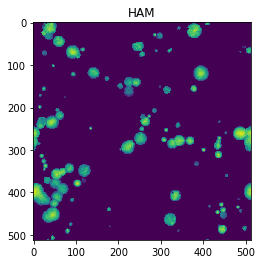

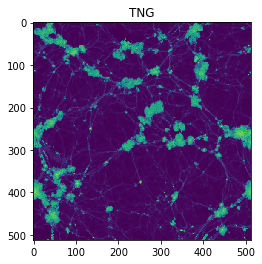

In [42]:
B_polluted=emulateBubbles(pos,M,dens,Bavg,indexes,dims=64,rescale_factor=1,Mthresh=Mass_threshold)
#A,Masses and Envirs are loaded from file unless specified.  Rescale factor is 1 as we are feeding the 
#sim back into itself

box_size=100
plt.imshow(np.log(1e-14+(np.sqrt(np.sum(B_polluted[:,:,256,:]**2,axis=2)))))
plt.title('HAM')
plt.show()
plt.imshow(np.log(1e-14+(np.sqrt(np.sum(BOG[:,:,256,:]**2,axis=2)))))
plt.title('TNG')
plt.show()

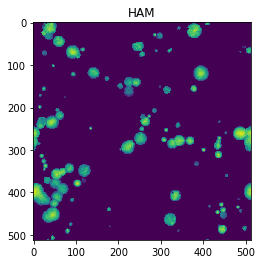

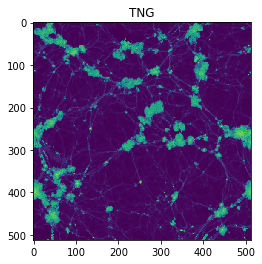

In [43]:
plt.imshow(np.log(1e-14+(np.sqrt(np.sum(B_polluted[:,:,256,:]**2,axis=2)))))
plt.title('HAM')
plt.show()
plt.imshow(np.log(1e-14+(np.sqrt(np.sum(BOG[:,:,256,:]**2,axis=2)))))
plt.title('TNG')
plt.show()

z=0
z=0.0
z=0.0
z=0.1
z=0.1
z=0.1
z=0.1
z=0.2
z=0.2
z=0.2
z=0.2
z=0.2
z=0.3
z=0.3
z=0.3
z=0.3
z=0.3
z=0.4
z=0.4
z=0.4
z=0.4
z=0.4
z=0.5
z=0.5
z=0.5
z=0.5
z=0.5
z=0.6
z=0.6
z=0.6
z=0.6
z=0.6
z=0.7
z=0.7
z=0.7
z=0.7
z=0.7
z=0.8
z=0.8
z=0.8
z=0.8
z=0.8
z=0.9
z=0.9
z=0.9
z=0.9
z=0.9
z=1.0
z=1.0
z=0
z=0.0
z=0.0
z=0.1
z=0.1
z=0.1
z=0.1
z=0.2
z=0.2
z=0.2
z=0.2
z=0.2
z=0.3
z=0.3
z=0.3
z=0.3
z=0.3
z=0.4
z=0.4
z=0.4
z=0.4
z=0.4
z=0.5
z=0.5
z=0.5
z=0.5
z=0.5
z=0.6
z=0.6
z=0.6
z=0.6
z=0.6
z=0.7
z=0.7
z=0.7
z=0.7
z=0.7
z=0.8
z=0.8
z=0.8
z=0.8
z=0.8
z=0.9
z=0.9
z=0.9
z=0.9
z=0.9
z=1.0
z=1.0
7.5269317731738665


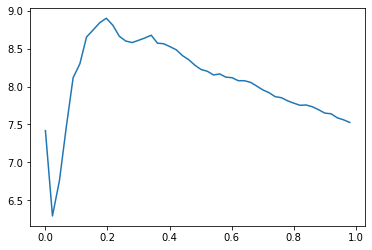

In [44]:
box_size=100 #in Mpc
znorm=1
#the redshift at which the refence simulation agrees with the HAM model.  If the model was perfect then this parameter 
#would not matter
C=Compute_Norm(B_polluted,dens,box_size,znorm,BOG)
print(C)

interpolating profiles
0 %
15 %
31 %
46 %
62 %
77 %
93 %
0%
1%
3%
5%
7%
9%
11%
13%
15%
17%
19%
21%
23%
25%
27%
29%
31%
33%
35%
37%
39%
41%
43%
45%
47%
49%
51%
53%
55%
57%
59%
61%
63%
65%
67%
69%
71%
73%
75%
77%
79%
81%
83%
85%
87%
89%
91%
93%
95%
97%
99%


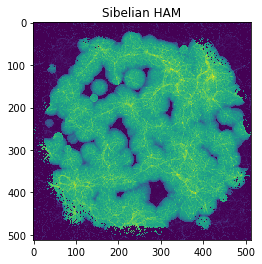

In [45]:
#this is extremely slow, so may want to experiment with higher threshold masses.  

B_sib=emulateBubbles(pos_sib,M_sib,dens_sib,Bavg,indexes,dims=64,rescale_factor=936.8/2/100,Mthresh=Mass_threshold)*C+p_field_gen(dens_sib,amplitude=1e-14,frac=0.1,scale=16)

#B_sib=emulateBubbles(pos_sib,M_sib,dens_sib,Bavg,indexes,dims=64,rescale_factor=936.8/2/100,Mthresh=3e11)*C+p_field_gen(dens_sib,amplitude=1e-14,frac=0.1,scale=16)
#multiply by corrective constant and add primoridal field
plt.imshow(np.log(1e-14+(np.sqrt(np.sum(B_sib[:,:,256,:]**2,axis=2)))))
plt.title('Sibelian HAM')
plt.show()



allocating map
initializing views
progress?


|################################################################|Time: 0:00:23


19 Clusters found


allocating map
initializing views
progress?


|################################################################|Time: 0:00:23


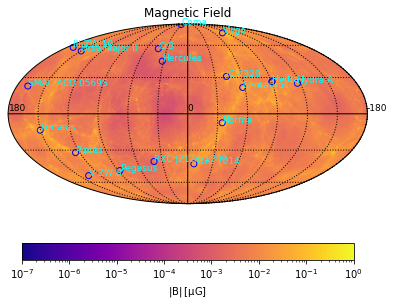

In [49]:
#for further visualisation
#requires use of cosmotool

import cosmotool

def MW_plt(arr,floor,Log,title,cmin,cmax,cmap,Type,axes=None,cbar_title=""):
    f=plt.figure()
    
    if(Log*(Type=="RM")):
        
        x=np.where(arr>10**cmax)[0]
        if(x.size>0):
            arr[x]=10**cmax
        x=np.where(arr<-10**cmin)[0]
        if(x.size>0):
            arr[x]=-10**cmin
        norm=colors.SymLogNorm(linthresh=10**floor,linscale=10**floor,vmax=10**cmax,vmin=-10**cmax)
        hp.mollview(arr, fig=1, coord='CG',title=title,notext=True,bgcolor='white',badcolor='white',cmap=cmap,norm=norm,max=10**cmax,min=-10**cmin,cbar=False)
    
    elif(Log):
        x=np.where(arr>10**cmax)[0]
        if(x.size>0):
            arr[x]=10**cmax
        x=np.where(arr<10**cmin)[0]
        if(x.size>0):
            arr[x]=10**cmin
        
        
        #hp.mollview(np.log10(abs(arr)+floor), fig=1, coord='G',title=title,notext=True,min=cmin,max=cmax,cmap=cmap)
        norm=colors.LogNorm(vmax=10**cmax,vmin=10**cmin)
        hp.mollview(arr, fig=1, coord='CG',title=title,notext=True,cmap=cmap,badcolor='white',bgcolor='white',norm=norm,max=10**cmax,min=10**cmin,cbar=False)

    else:
        x=np.where(arr>cmax)[0]
        if(x.size>0):
            arr[x]=cmax
        x=np.where(arr<cmin)[0]
        if(x.size>0):
            arr[x]=cmin
        x=np.where(arr!=0)[0]
        floor=np.min((arr[x])+floor)
        norm=colors.Norm(vmax=cmax,vmin=cmin)
        hp.mollview(arr+floor, fig=1, coord='CG',title=title,badcolor='white',notext=True,min=cmin,max=cmax,cmap=cmap,bgcolor='white',cbar=False)
        norm=None
    if((Type=="delection")+(Type=="RM")):
        grat_kwargs=dict(color='w')
        hp.graticule(**grat_kwargs)
    else:
        hp.graticule()
    
    plt.colorbar(plt.cm.ScalarMappable(norm=norm,cmap=cmap),shrink=0.8,ax=axes,label=cbar_title,orientation='horizontal')
   
    return f

def cat_proc():
    f=np.load('/home/ramsoy/atch/catalog.npz',allow_pickle=True)
    finame=f['arr_0']
    ra=f['arr_2']
    dec=f['arr_3']
    z=f['arr_4']
    
    
    eq = SkyCoord(ra, dec, frame='icrs',unit=(u.hourangle, u.deg))
    l, b = eq.galactic.l.value, eq.galactic.b.value  
    names=np.concatenate((finame,["Virgo"]))
    ra=np.concatenate((l,[279.6763]))
    dec=np.concatenate((b,[74.4596]))
    z=np.concatenate((z,[0.0038]))
    names=np.concatenate((names,["Pisces"]))
    ra=np.concatenate((ra,[124.7055]))
    dec=np.concatenate((dec,[ -32.1947  ]))
    z=np.concatenate((z,[0.018000]))
    
    names=np.concatenate((names,["Pegasus"]))
    ra=np.concatenate((ra,[87.7031 ]))
    dec=np.concatenate((dec,[ -48.3286 ]))
    z=np.concatenate((z,[0.018000]))
    #simbad doesn't have a redshift
    
    
    
    return ra,dec,names,z


def MW_name_plt(gal_tup,Type,Sim):
    ra=gal_tup[0]
    dec=gal_tup[1]
    names=gal_tup[2]
   
    ra=np.array([136.93735874, 150.38174584, 168.57327953, 243.1381037 ,
        170.61562534, 269.63026749, 149.25536886,  58.08616113,
         42.87520738,  31.58781883,  39.90336886, 302.41203918,
        317.45967005, 325.33074435, 352.5911349 , 269.57866176,
        279.6763    , 124.7055    ,  87.7031    ])
    dec=np.array([-53.259941  , -13.38152317,  22.80672409,  25.07020132,
         57.88772667,  26.50587452,  54.17871741,  87.95760795,
         56.56097245,  44.52158698, -39.9750057 ,  21.56331536,
         30.93993674,  -7.25575427, -42.1546694 ,  26.49532999,
         74.4596    , -32.1947    , -48.3286    ])

    names=np.array(['V ZW 8 Group', 'Perseus Cluster', 'SMAC ACO 0569S',
        'Hydra A Cluster', 'III ZW 10 Group', 'Hydra I Cluster',
        'Ursa Major II Cluster', 'Coma Cluster', 'CrB Cluster',
        'Hercules Cluster', 'RXC J2127-1209', 'Centaurus Group',
        'IC 4329 Group', 'Norma Cluster', 'NGC 7014 Group',
        'Hydra I Cluster', 'Virgo', 'Pisces', 'Pegasus'], dtype='<U21')
  
    #hp.projscatter(ra,dec,lonlat=True)
    col='aqua'
    print(ra.size,"Clusters found")
    for i in range(ra.size):
        if(names[i][0:3]!='ACO'):
            #name transformations
            t=names[i]
            ft=t.find("Cluster")
            if(ft!=-1):
                t=t[0:ft-1]
            
            ft=t.find("Group")
            if(ft!=-1):
            #    continue
                t=t[0:ft-1]
 
            scatter_kwargs = dict(marker="o", facecolors='none', edgecolors='b', linewidth=1.)
            hp.projscatter(ra[i],dec[i],lonlat=True,coord="G",**scatter_kwargs)
            
            hp.projtext(ra[i],dec[i],t,lonlat=True,coord="G",size=9,color=col)
           
    ras=[-179,0,179]
    decs=2
    n=['-180','0','180']
    for i in range(3):
        hp.projtext(ras[i],decs,n[i],lonlat=True,coord="G",size=9,color='black')

def fg_load(fname,subtract):
    #'faraday2020.hdf5'
    f=h5.File(fname,'r')

    asm=np.array(f[list(f.keys())[0]],float)
    if(subtract==1):
        asd=np.array(f[list(f.keys())[1]],float)

        asd=np.random.normal(0,asd)
        return asd
    return asm



nside=256
dist=100

Bhp=cosmotool.spherical_projection(nside,np.transpose(np.sqrt(np.sum(B_sib**2,axis=3)),(2,1,0)), min_distance=0, max_distance=dist, progress=1,integrator_id=1)/dist


MW_plt(abs(Bhp/1e-6),-8,True,"Magnetic Field",-7,0,"plasma","B",None,r'$\rm |B|\:[\mu G]$')
gt=cat_proc()
MW_name_plt(gt,"B","HAM")

BhpOG=cosmotool.spherical_projection(nside,np.transpose(np.sqrt(np.sum(BOG**2,axis=3)),(2,1,0)), min_distance=0, max_distance=dist, progress=1,integrator_id=1)/dist




In [50]:
def norm(v):
    l=len(v.shape)
    
    L=np.sqrt(np.sum(v**2,axis=l-1))
    #if(L==0):
    #    L=1
    return L
def radial(s):
    r=np.zeros((s,s,s,3))
    
    t=np.linspace(-s/2,s/2,s)
    r[:,:,:,0]=np.expand_dims(t,(1,2))
    r[:,:,:,1]=np.expand_dims(t,(0,2))
    r[:,:,:,2]=np.expand_dims(t,(0,1))
    r/=np.expand_dims(norm(r),3)
    return r
dirs=radial(512)
RMsss=dens_sib.reshape((512,512,512))*(dirs[:,:,:,0]*B_sib[:,:,:,0].reshape((512,512,512))+dirs[:,:,:,1]*B_sib[:,:,:,1].reshape((512,512,512))+dirs[:,:,:,2]*B_sib[:,:,:,2].reshape((512,512,512)))


RMhp=cosmotool.spherical_projection(nside,np.transpose(RMsss,(2,1,0)), min_distance=0, max_distance=dist, progress=1,integrator_id=1)


allocating map
initializing views
progress?


|################################################################|Time: 0:00:23


19 Clusters found


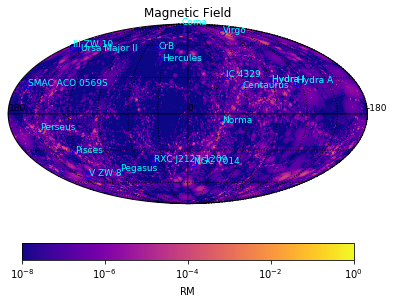

In [59]:
MW_plt(abs(RMhp),-8,True,"Magnetic Field",-8,0,"plasma","g",None,r'$\rm RM$')
#gt=cat_proc()
MW_name_plt(gt,"RM","HAM")